In [1]:

# import os

# os.environ["KERAS_BACKEND"] = "jax"
# import keras
# from keras import layers
# import jax
# import jax.numpy as jnp


In [2]:
from eqr.epistemic_quantile_regressor import EpistemicQuantileRegressor


In [47]:
import matplotlib.pyplot as plt
import scienceplots
import optuna
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_pinball_loss

##
from sklearn.model_selection import train_test_split

plt.style.use(["science", "notebook", "muted"])
plt.rcParams["text.usetex"] = False


def f(x):
    """The function to predict."""
    return x * np.sin(x)


rng = np.random.RandomState(42)
X = np.atleast_2d(rng.uniform(0, 10.0, size=1000)).T
expected_y = f(X).ravel()

sigma = 0.5 + X.ravel() / 10
noise = rng.lognormal(sigma=sigma) - np.exp(sigma**2 / 2)
y = expected_y + noise


X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [48]:
mask = (X_train[:, 0] > 4) & (X_train[:, 0] < 6)
X_train = X_train[~mask]
y_train = y_train[~mask]

mask = (X_test[:, 0] > 4) & (X_test[:, 0] < 6)
X_test = X_test[~mask]
y_test = y_test[~mask]

# mask = (X_train[:, 0] > 7) & (X_train[:, 0] < 9)
# X_train = X_train[~mask]
# y_train = y_train[~mask]

# mask = (X_test[:, 0] > 7) & (X_test[:, 0] < 9)
# X_test = X_test[~mask]
# y_test = y_test[~mask]


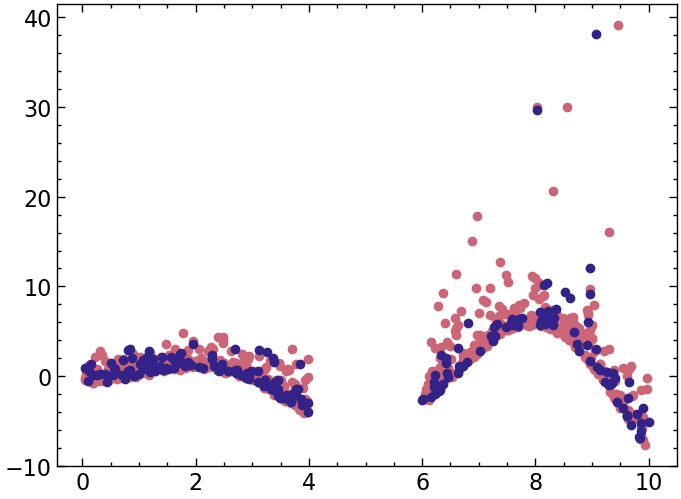

In [49]:
plt.scatter(X_train, y_train)
plt.scatter(X_test, y_test)

In [50]:
xx = np.linspace(-5, 15, 100)[:,np.newaxis]

In [51]:
# method = "gbr"
# method = "ann"
method = "lgb"
eqr_model = EpistemicQuantileRegressor([(-5, 15)], 1000, method=method)

X_ood, y_ood = eqr_model.generate_synthetic_ood_data(
    X_train,
    y_train,
    scaling_factor=5,
    gm_kwargs={"n_components": 3},
)

X_aug, y_aug = eqr_model.augment_training_data(X_train, y_train, X_ood, y_ood)


print(X_train.shape, X_test.shape, X_ood.shape, X_aug.shape)


(613, 1) (195, 1) (607, 1) (1220, 1)


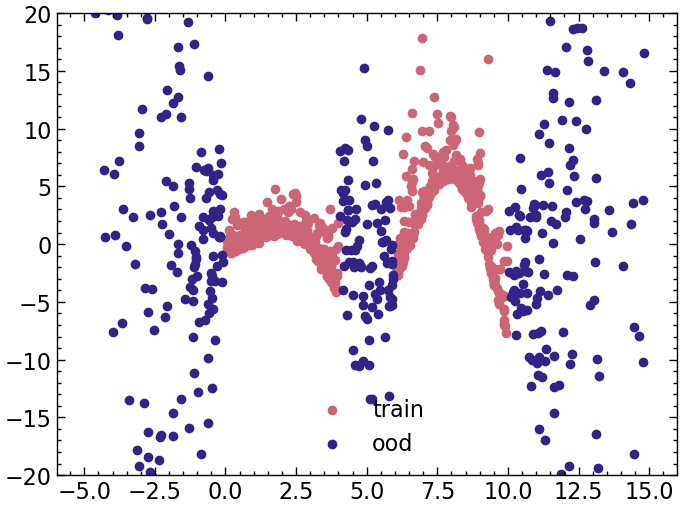

In [52]:
plt.figure()
plt.scatter(X_train, y_train, label="train")
plt.scatter(X_ood, y_ood, label="ood")
plt.legend()
# plt.xlim(0, 10)
plt.ylim(-20, 20)
plt.show()

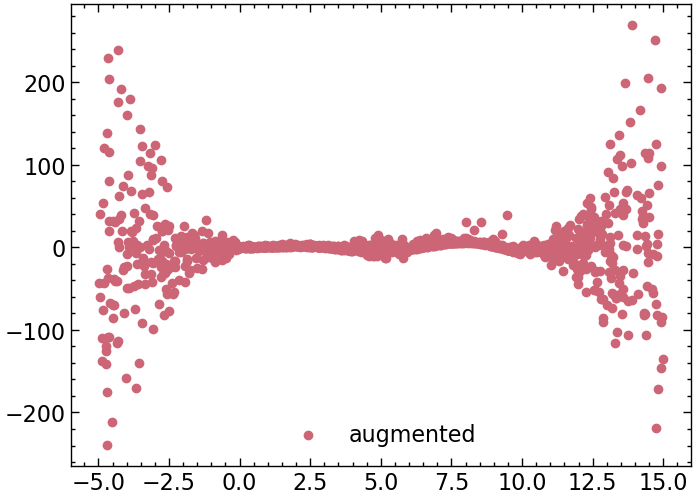

In [53]:

plt.figure()
plt.scatter(X_aug, y_aug, label="augmented")
plt.legend()
plt.show()


In [54]:
%%time
if method == "ann":
    params = dict(epochs=1000, batch_size=32, verbose=0)
elif method == "gbr":
    params = dict(n_trials=100)
elif method == "lgb":
    params = dict(
        n_trials=30,
        # fixed_params={"num_leaves": 31},
        fixed_params={"num_iterations": 100},
        # fixed_params=None,
        search_params=[["num_leaves", "int", 91, 3100]],
        cv_params={"nfold": 2},
    )
else:
    raise ValueError(f"unknown {method = }")

eqr_model.fit(X_aug, y_aug, **params)

  0%|          | 0/30 [00:00<?, ?it/s]

/home/sebastian.khan/.conda/envs/ppmhm/lib/python3.10/site-packages/lightgbm/engine.py:738: UserWarning: Found 'num_iterations' in params. Will use it instead of 'num_boost_round' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'num_boost_round' argument")
/home/sebastian.khan/.conda/envs/ppmhm/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

CPU times: user 49.6 s, sys: 6.95 s, total: 56.5 s
Wall time: 56.7 s


In [55]:
for k in eqr_model.study.keys():
    print(k, eqr_model.study[k].best_params)

0.05 {'num_leaves': 2055}
0.5 {'num_leaves': 144}
0.95 {'num_leaves': 92}


In [56]:
for k in eqr_model.params.keys():
    print(k, eqr_model.params[k])

0.05 {'objective': 'quantile', 'metric': 'quantile', 'num_iterations': 100, 'max_depth': -1, 'learning_rate': 0.1, 'verbose': -1, 'min_data_in_leaf': 1, 'seed': 5093840343, 'num_threads': 0, 'alpha': 0.05, 'num_leaves': 2055}
0.5 {'objective': 'quantile', 'metric': 'quantile', 'num_iterations': 100, 'max_depth': -1, 'learning_rate': 0.1, 'verbose': -1, 'min_data_in_leaf': 1, 'seed': 5093840343, 'num_threads': 0, 'alpha': 0.5, 'num_leaves': 144}
0.95 {'objective': 'quantile', 'metric': 'quantile', 'num_iterations': 100, 'max_depth': -1, 'learning_rate': 0.1, 'verbose': -1, 'min_data_in_leaf': 1, 'seed': 5093840343, 'num_threads': 0, 'alpha': 0.95, 'num_leaves': 92}


In [57]:
yhats = eqr_model.predict(xx)

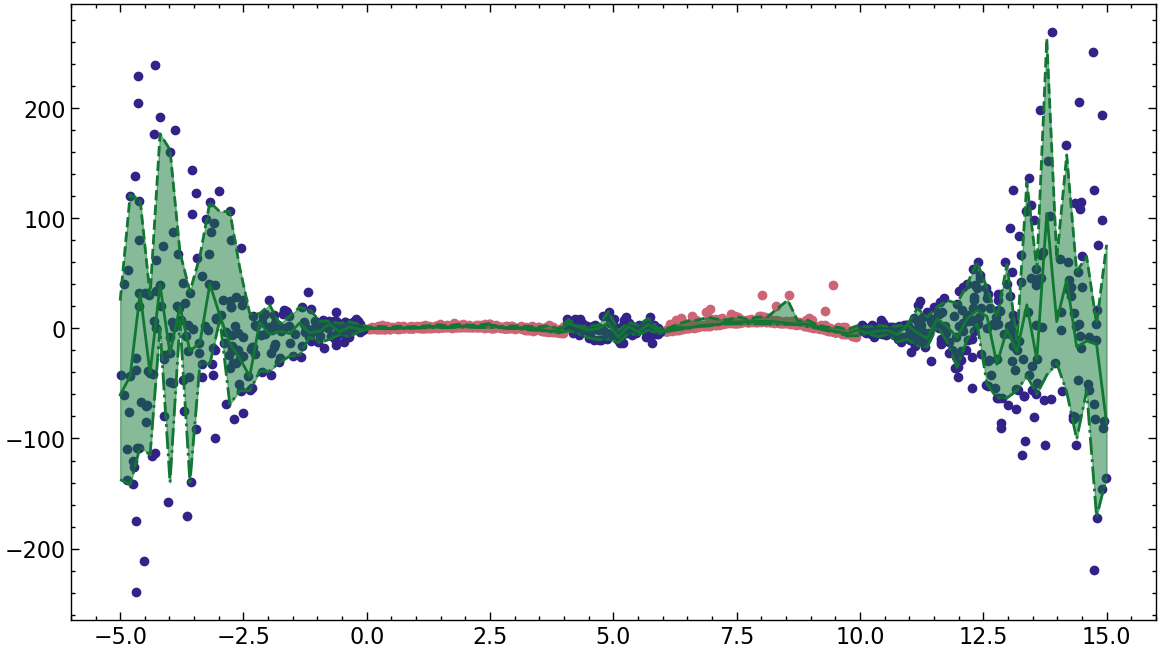

In [58]:
plt.figure(figsize=(14,8))
plt.scatter(X_train, y_train, label="train")
plt.scatter(X_ood, y_ood, label="ood")
plt.plot(xx, yhats[0], c="C3", ls="-.")
plt.plot(xx, yhats[1], c="C3")
plt.plot(xx, yhats[2], c="C3", ls="--")
plt.fill_between(xx[:, 0], yhats[0][:, 0], yhats[2][:, 0], color="C3", alpha=0.5)

(-5.0, 15.0)

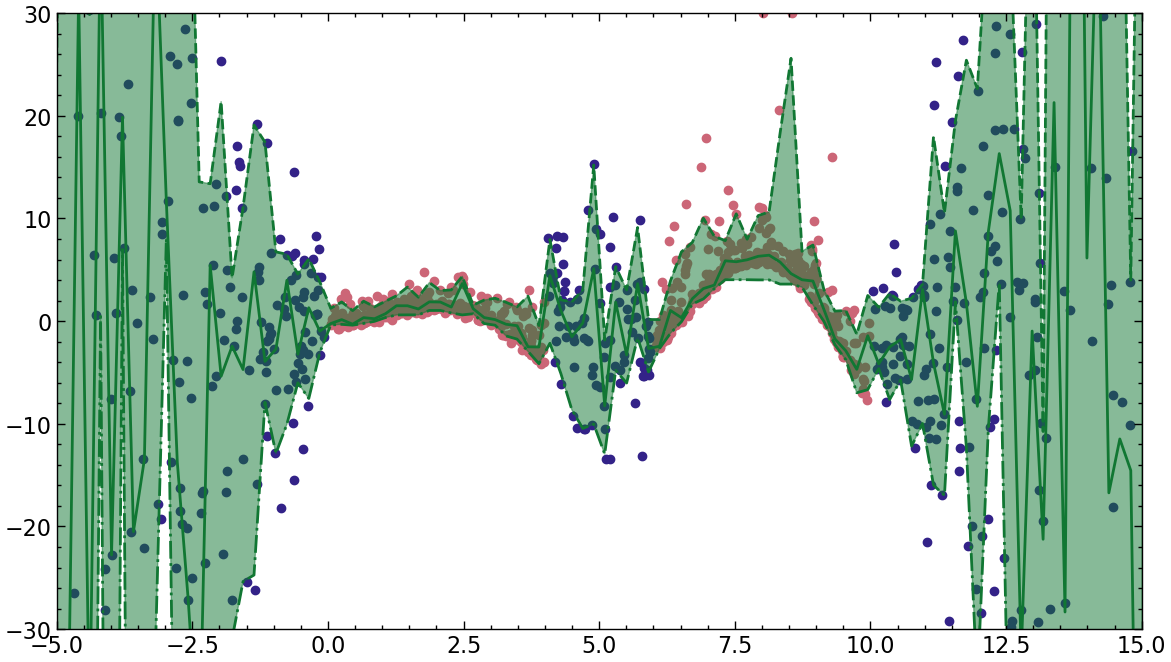

In [59]:
plt.figure(figsize=(14,8))
plt.scatter(X_train, y_train, label="train")
plt.scatter(X_ood, y_ood, label="ood")
plt.plot(xx, yhats[0], c="C3", ls="-.")
plt.plot(xx, yhats[1], c="C3")
plt.plot(xx, yhats[2], c="C3", ls="--")
plt.fill_between(xx[:, 0], yhats[0][:, 0], yhats[2][:, 0], color="C3", alpha=0.5)
plt.ylim(-30, 30)
plt.xlim(-5, 15)

# optuna for keras

In [ ]:
# https://github.com/optuna/optuna-examples/blob/main/keras/keras_simple.py
# https://github.com/optuna/optuna-examples/blob/main/keras/keras_integration.py

In [107]:

import os

os.environ["KERAS_BACKEND"] = "jax"
import keras
from keras import layers
import jax
import jax.numpy as jnp


import optuna

from keras.backend import clear_session
from keras.layers import Dense
from keras.layers import Input
from keras.models import Sequential
from keras.optimizers import Adam

import sklearn.model_selection




def tilted_loss(q, y, f):
    """
    Keras quantile loss from [here](https://github.com/sachinruk/KerasQuantileModel/blob/master/Keras%20Quantile%20Model.ipynb)
    and [here](https://github.com/cgarciae/quantile-regression)
    """
    e = y - f
    return jnp.mean(jnp.maximum(q * e, (q - 1) * e), axis=-1)


def create_model(trial, input_shape, output_shape, alpha):

    
    n_layers = trial.suggest_int("n_layers", 2, 4)
    
    model = Sequential()
    model.add(Input(shape=input_shape))
    for i in range(n_layers):
        units = trial.suggest_int(f"units_l{i}", 2, 128, log=True)
        # activation= trial.suggest_categorical(f"activation_l{i}", ["relu", "selu", "tanh"])
        activation='selu'
        model.add(Dense(units=units, activation=activation))
    model.add(Dense(output_shape, activation="linear"))

    # We compile our model with a sampled learning rate.
    # learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
    learning_rate = 1e-3
    model.compile(
        loss=lambda y, f: tilted_loss(alpha, y, f),
        optimizer=Adam(learning_rate=learning_rate),
    )
    return model


def objective(trial, X, y, alpha, epochs, batch_size):
    # Clear clutter from previous Keras session graphs.
    clear_session()

    input_shape = (X.shape[1],)
    output_shape = 1
    
    model = create_model(trial, input_shape, output_shape, alpha)

    X_train, X_valid, y_train, y_valid = sklearn.model_selection.train_test_split(X, y, test_size=0.2)

    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=False, validation_data=(X_valid, y_valid), shuffle=True)


    # Evaluate the model accuracy on the validation set.
    score = model.evaluate(X_valid, y_valid, verbose=0)
    return score

In [117]:
%%time
alpha = 0.5
epochs = 1000
batch_size = 32
study = optuna.create_study(direction="minimize")
study.optimize(
    lambda trial: objective(trial, X_aug, y_aug, alpha, epochs, batch_size),
    n_trials=100,
    timeout=600)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-11-23 12:31:40,812] A new study created in memory with name: no-name-5de1b2c1-a58e-45a3-865d-f8455ef1c895
[I 2024-11-23 12:31:50,813] Trial 0 finished with value: 25.99223518371582 and parameters: {'n_layers': 2, 'units_l0': 18, 'units_l1': 4}. Best is trial 0 with value: 25.99223518371582.
[I 2024-11-23 12:32:00,952] Trial 1 finished with value: 45.367332458496094 and parameters: {'n_layers': 2, 'units_l0': 11, 'units_l1': 85}. Best is trial 0 with value: 25.99223518371582.
[I 2024-11-23 12:32:11,931] Trial 2 finished with value: 35.97870635986328 and parameters: {'n_layers': 3, 'units_l0': 2, 'units_l1': 38, 'units_l2': 58}. Best is trial 0 with value: 25.99223518371582.
[I 2024-11-23 12:32:22,122] Trial 3 finished with value: 41.3686408996582 and parameters: {'n_layers': 2, 'units_l0': 48, 'units_l1': 50}. Best is trial 0 with value: 25.99223518371582.
[I 2024-11-23 12:32:33,623] Trial 4 finished with value: 34.026756286621094 and parameters: {'n_layers': 4, 'units_l0': 6, '

Number of finished trials: 58
Best trial:
  Value: 21.662635803222656
  Params: 
    n_layers: 3
    units_l0: 36
    units_l1: 8
    units_l2: 3
CPU times: user 12min 16s, sys: 1min 10s, total: 13min 26s
Wall time: 10min 6s


In [118]:
input_shape = (X_train.shape[1],)
output_shape = 1

In [119]:
models= {}
models[0.05] = create_model(trial, input_shape, output_shape, 0.05)
models[0.5] = create_model(trial, input_shape, output_shape, 0.5)
models[0.95] = create_model(trial, input_shape, output_shape, 0.95)

In [126]:
models[0.95].summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_11 (Dense)                │ (None, 36)             │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 8)              │           296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 3)              │            27 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │             4 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,199 (4.68 KB)

 Trainable params: 399 (1.56 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 800 (3.12 KB)

In [120]:
historys={}
historys[0.05] = models[0.05].fit(X_aug, y_aug, epochs=1000, batch_size=batch_size, verbose=False, validation_split=0.2)
historys[0.5] = models[0.5].fit(X_aug, y_aug, epochs=1000, batch_size=batch_size, verbose=False, validation_split=0.2)
historys[0.85] = models[0.95].fit(X_aug, y_aug, epochs=1000, batch_size=batch_size, verbose=False, validation_split=0.2)

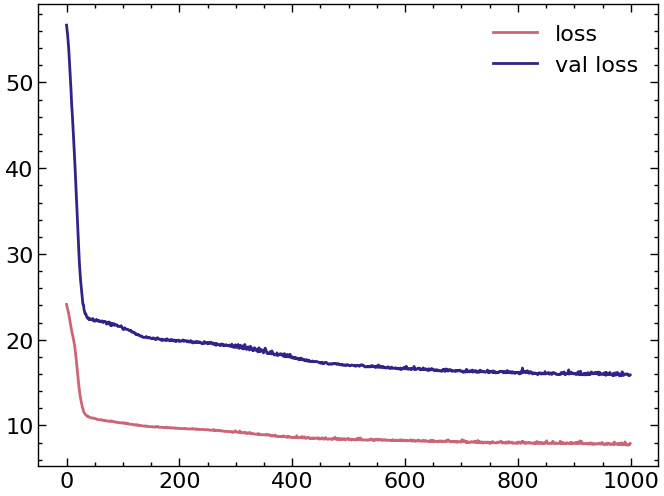

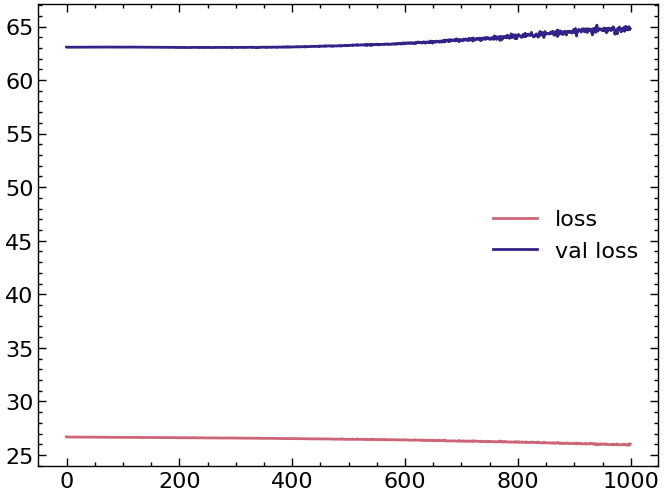

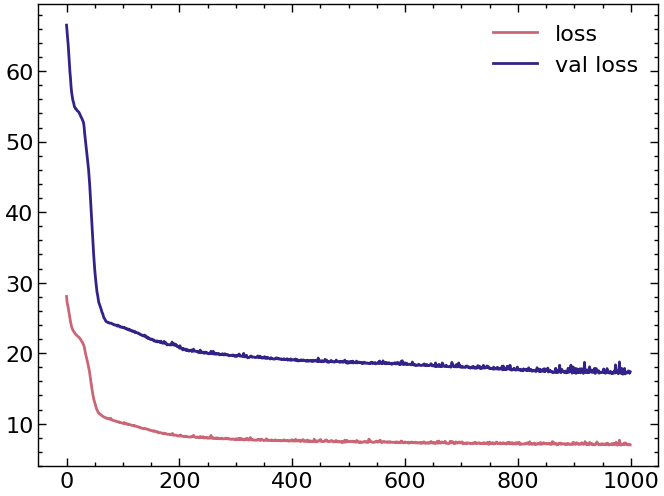

In [121]:
for k in historys.keys():
    plt.figure()
    plt.plot(historys[k].history['loss'], label='loss')
    plt.plot(historys[k].history['val_loss'], label='val loss')
    plt.legend()

In [122]:
yhats = [
    models[0.05](xx),
    models[0.5](xx),
    models[0.95](xx)
]

(-5.0, 15.0)

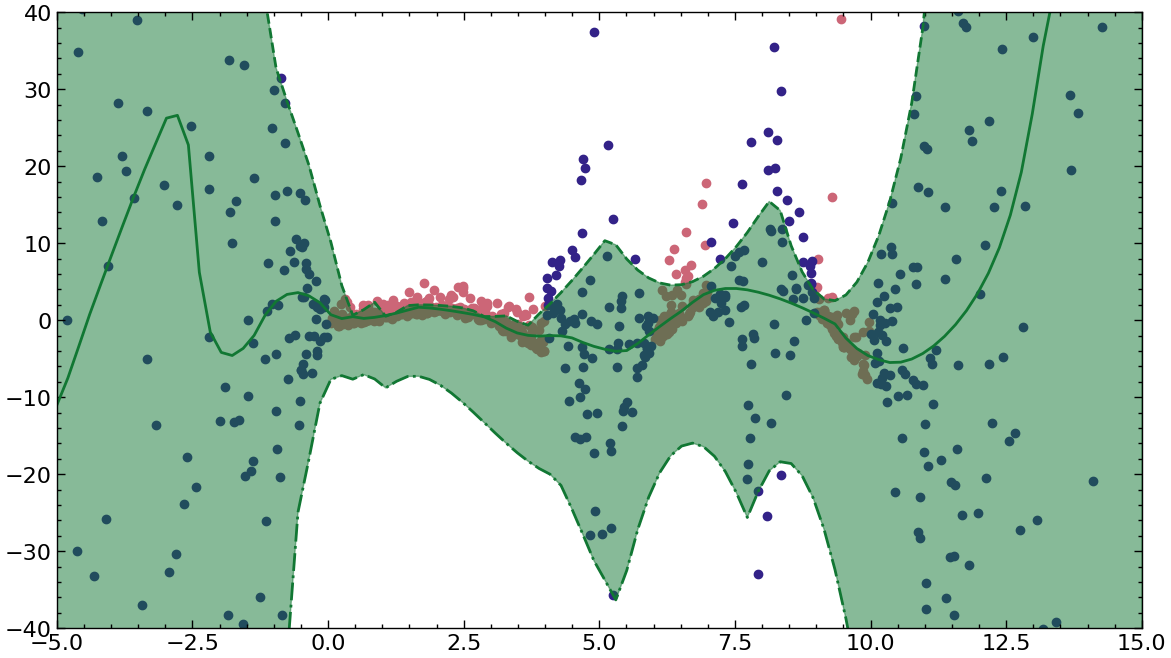

In [123]:
plt.figure(figsize=(14,8))
plt.scatter(X_train, y_train, label="train")
plt.scatter(X_ood, y_ood, label="ood")
plt.plot(xx, yhats[0], c="C3", ls="-.")
plt.plot(xx, yhats[1], c="C3")
plt.plot(xx, yhats[2], c="C3", ls="--")
plt.fill_between(xx[:, 0], yhats[0][:, 0], yhats[2][:, 0], color="C3", alpha=0.5)
plt.ylim(-40, 40)
plt.xlim(-5, 15)